In [0]:
# Load in one of the tables
df = spark.sql("select * from default.reviews_train")
print((df.count(), len(df.columns)))

(3138710, 11)

In [0]:
df.printSchema()

root
-- reviewID: integer (nullable = true)
-- overall: double (nullable = true)
-- verified: boolean (nullable = true)
-- reviewTime: string (nullable = true)
-- reviewerID: string (nullable = true)
-- asin: string (nullable = true)
-- reviewerName: string (nullable = true)
-- reviewText: string (nullable = true)
-- summary: string (nullable = true)
-- unixReviewTime: integer (nullable = true)
-- label: integer (nullable = true)

In [0]:
df.show(10)


In [0]:
# Let's look at some quick summary statistics
df.describe().show()

+-------+-----------------+-----------------+----------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+
summary| reviewID| overall|reviewTime| reviewerID| asin|reviewerName| reviewText| summary| unixReviewTime| label|
+-------+-----------------+-----------------+----------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+
 count| 3138710| 3138710| 3138710| 3138710| 3138710| 3138480| 3138710| 3138339| 3138710| 3138710|
 mean| 1569355.5|4.319868034957037| null| null| 4.429350743222517E7| NaN| 7.852610784558824E7| Infinity|1.3923188409546597E9|0.17951674414010851|
 stddev|906067.6760416409|1.124628313934273| null| null|2.7252114394108355E8| NaN| 7.930642215301824E8| NaN|1.0328703303906891E8|0.38378448332434417|
 min| 1| 1.0|01 1, 1998|A0001528BGUBOEVR6T5U| 0000013765| | | | 843004800| 0|
 max| 3138710| 5.0|12 9, 2017| AZZZYAYJQSDOJ| B01HIZGKOE| ~~~|~~~~~ALL GREAT ...|~~~~(,,,___,,,)(=...| 1538265600| 1|
+-------+-----------------+-----------------+----------+--------------------+--------------------+------------+--------------------+--------------------+--------------------+-------------------+

In [0]:
# The count of each overall rating

from pyspark.sql.functions import col
df.groupBy("overall").count().orderBy(col("overall").asc()).show()

+-------+-------+
|overall|  count|
+-------+-------+
|    1.0| 161250|
|    2.0| 137786|
|    3.0| 262627|
|    4.0| 551125|
|    5.0|2025922|
+-------+-------+



In [0]:
# The most common product IDs
df.groupBy("asin").count().orderBy(col("count","label").desc()).show(10)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3383572321263711> in <module> 
 1 # The most common product IDs 
 ----> 2 df . groupBy ( "asin" ) . count ( ) . orderBy ( col ( "count" , "label" ) . desc ( ) ) . show ( 10 ) 

 NameError : name 'col' is not defined

In [0]:
from pyspark.ml.feature import Imputer, VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.types import StringType, DoubleType

In [0]:
# numeric features
numeric_features =[f.name for f in df.schema.fields if not isinstance(f.dataType, StringType)]
print(numeric_features)

['reviewID', 'overall', 'verified', 'unixReviewTime', 'label']

In [0]:
# categorical features
categorical_features = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
print(categorical_features)

['reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary']

In [0]:
df_eda = df
# Convert Unix timestamp to readable date
from pyspark.sql.functions import date_format
from pyspark.sql.functions import from_unixtime, to_date
from pyspark.sql.types import *

df_eda = df_eda.withColumn("reviewTime", to_date(from_unixtime(df_eda.unixReviewTime))) \
                                                .drop("unixReviewTime")

# Extract year from reviewTime
from pyspark.sql.functions import year

df_eda = df_eda.withColumn("year", year(df_eda["reviewTime"]))

# Extract sentiment from reviewText feature
import nltk
nltk.download('all')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf

## initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

## define the udf
sentiment_udf = udf(lambda x: sia.polarity_scores(x)["compound"])

## use the udf to add a new column "sentiment" to the dataframe
df_eda = df_eda.withColumn("sentiment", sentiment_udf("reviewText"))

df_eda = df_eda.withColumn("sentiment", df_eda["sentiment"].cast('double'))

## convert sentiment scores to  "Positive", "Negative", or "Neutral"

def convert_score(score):
    if score >= 0.5:
        return "Positive"
    elif score <= -0.5:
        return "Negative"
    else:
        return "Neutral"
    
convert_udf = udf(convert_score, StringType())
df_eda = df_eda.withColumn("sentiment_label", convert_udf("sentiment"))


from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover


# We'll tokenize the text using a simple RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="reviewText", outputCol="words", pattern="\\W")


# Remove standard Stopwords
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")



pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover])

pipelineFit = pipeline.fit(df_eda)
df_eda = pipelineFit.transform(df_eda)

#lemmatize filtered words
import nltk
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemmatizer = WordNetLemmatizer()

# function to lemmatize the text
def lemmatize_text(filtered):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered]
    return lemmatized_words

lemmatize_udf = udf(lemmatize_text, ArrayType(StringType()))

df_eda = df_eda.withColumn("lemmatized_text", lemmatize_udf("filtered"))

# Extract bigram

from pyspark.ml.feature import NGram
from pyspark.sql.functions import array_union

ngram = NGram(n = 2, inputCol="lemmatized_text", outputCol="reviewBigrams")
df_eda = ngram.transform(df_eda)

df_eda = df_eda.withColumn("reviewNgrams", \
                                                         array_union(df_eda.filtered, \
                                                                    df_eda.reviewBigrams))



df_eda.show(5)

[nltk_data] Downloading collection 'all'
[nltk_data] | 
[nltk_data] | Downloading package abc to /root/nltk_data...
[nltk_data] | Package abc is already up-to-date!
[nltk_data] | Downloading package alpino to /root/nltk_data...
[nltk_data] | Package alpino is already up-to-date!
[nltk_data] | Downloading package averaged_perceptron_tagger to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package averaged_perceptron_tagger is already up-
[nltk_data] | to-date!
[nltk_data] | Downloading package averaged_perceptron_tagger_ru to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package averaged_perceptron_tagger_ru is already
[nltk_data] | up-to-date!
[nltk_data] | Downloading package basque_grammars to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package basque_grammars is already up-to-date!
[nltk_data] | Downloading package bcp47 to /root/nltk_data...
[nltk_data] | Package bcp47 is already up-to-date!
[nltk_data] | Downloading package biocreative_ppi to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package biocreative_ppi is already up-to-date!
[nltk_data] | Downloading package bllip_wsj_no_aux to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package bllip_wsj_no_aux is already up-to-date!
[nltk_data] | Downloading package book_grammars to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package book_grammars is already up-to-date!
[nltk_data] | Downloading package brown to /root/nltk_data...
[nltk_data] | Package brown is already up-to-date!
[nltk_data] | Downloading package brown_tei to /root/nltk_data...
[nltk_data] | Package brown_tei is already up-to-date!
[nltk_data] | Downloading package cess_cat to /root/nltk_data...
[nltk_data] | Package cess_cat is already up-to-date!
[nltk_data] | Downloading package cess_esp to /root/nltk_data...
[nltk_data] | Package cess_esp is already up-to-date!
[nltk_data] | Downloading package chat80 to /root/nltk_data...
[nltk_data] | Package chat80 is already up-to-date!
[nltk_data] | Downloading package city_database to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package city_database is already up-to-date!
[nltk_data] | Downloading package cmudict to /root/nltk_data...
[nltk_data] | Package cmudict is already up-to-date!
[nltk_data] | Downloading package comparative_sentences to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package comparative_sentences is already up-to-
[nltk_data] | date!
[nltk_data] | Downloading package comtrans to /root/nltk_data...
[nltk_data] | Package comtrans is already up-to-date!
[nltk_data] | Downloading package conll2000 to /root/nltk_data...
[nltk_data] | Package conll2000 is already up-to-date!
[nltk_data] | Downloading package conll2002 to /root/nltk_data...
[nltk_data] | Package conll2002 is already up-to-date!
[nltk_data] | Downloading package conll2007 to /root/nltk_data...
[nltk_data] | Package conll2007 is already up-to-date!
[nltk_data] | Downloading package crubadan to /root/nltk_data...
[nltk_data] | Package crubadan is already up-to-date!
[nltk_data] | Downloading package dependency_treebank to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package dependency_treebank is already up-to-date!
[nltk_data] | Downloading package dolch to /root/nltk_data...
[nltk_data] | Package dolch is already up-to-date!
[nltk_data] | Downloading package europarl_raw to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package europarl_raw is already up-to-date!
[nltk_data] | Downloading package extended_omw to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package extended_omw is already up-to-date!
[nltk_data] | Downloading package floresta to /root/nltk_data...
[nltk_data] | Package floresta is already up-to-date!
[nltk_data] | Downloading package framenet_v15 to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package framenet_v15 is already up-to-date!
[nltk_data] | Downloading package framenet_v17 to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package framenet_v17 is already up-to-date!
[nltk_data] | Downloading package gazetteers to /root/nltk_data...
[nltk_da

In [0]:
#Overall-rating distribution
df_eda = df_eda.cache()
display(df_eda.groupBy("overall").count().orderBy("overall"))

overall,count
1.0,161250
2.0,137786
3.0,262627
4.0,551125
5.0,2025922


Output can only be rendered in Databricks

In [0]:
#Top 10 Reviewed Products
from pyspark.sql.functions import col
display(df_eda.groupBy("asin").count().orderBy(col("count").desc()).head(10))

asin,count
0007420412,17660
000711835X,16598
0007548672,14316
0007350899,7155
0007444117,7058
B000YGEVMI,6621
0007378033,5695
B0015TMHSI,5294
006017322X,4674
0007384289,4574


Output can only be rendered in Databricks

In [0]:
#Label Distribution
display(df_eda.groupBy("label").count().orderBy("label"))

label,count
0,2575259
1,563451


Output can only be rendered in Databricks

In [0]:
# Sentiment Distribution by Label
display(df_eda.groupBy("label", "sentiment_label").count().orderBy(col("count").desc()))

label,sentiment_label,count
0,Positive,1739775
0,Neutral,719786
1,Positive,402407
0,Negative,115698
1,Neutral,93183
1,Negative,67861


Output can only be rendered in Databricks

In [0]:
# Sentiment Distribution by Products (Top 100 Reviews)
display(df_eda.groupBy("asin", "sentiment_label").count().orderBy(col("count").desc()).head(100))

asin,sentiment_label,count
0007420412,Positive,12920
000711835X,Positive,12895
0007548672,Positive,9130
0007350899,Positive,4878
B000YGEVMI,Positive,4526
0007548672,Neutral,4022
0007444117,Positive,3868
0007420412,Neutral,3792
0007378033,Positive,3636
0007350783,Positive,3197


Output can only be rendered in Databricks

In [0]:
#ReveiwText Team frequency (1-gram)
spark.conf.set("spark.databricks.queryWatchdog.outputRatioThreshold", 10000000)
from pyspark.sql import functions as f
display(df_eda.select(f.explode('reviewNgrams').alias('col')).groupBy('col').count().sort(f.desc('count')).collect())

col,count
great,725621
one,692455
like,571703
good,558400
book,524221
well,497836
love,435745
read,411061
time,403464
use,391800


Output can only be rendered in Databricks

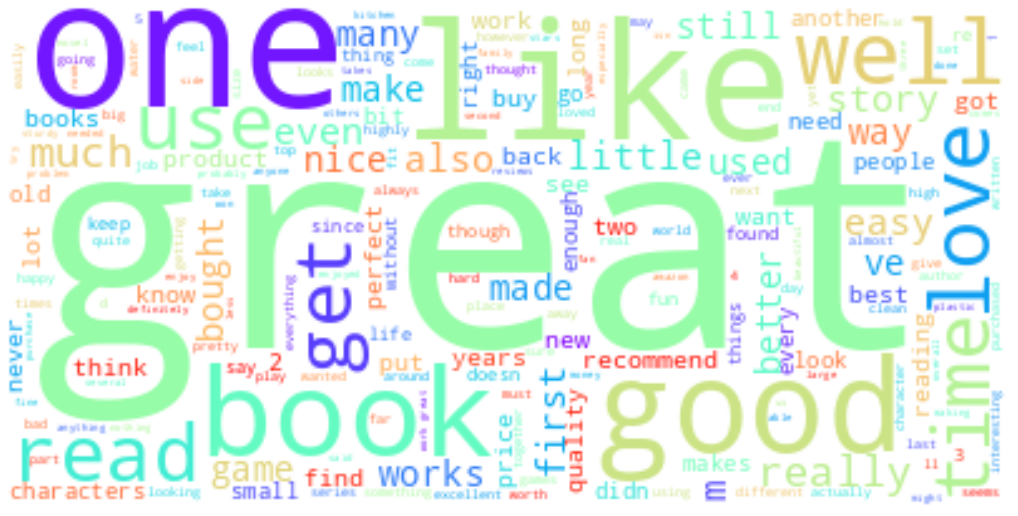

In [0]:
spark.conf.set("spark.databricks.queryWatchdog.outputRatioThreshold", 10000000)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Count the frequency of each bigram
bigram_word_freq = df_eda.select(f.explode('reviewNgrams').alias('col')).groupBy('col').count().sort(f.desc('count')).collect()

# Create a word cloud
wordcloud = WordCloud(background_color='white',
                      random_state=42,
                      colormap='rainbow').generate_from_frequencies(dict(bigram_word_freq))

# Display the word cloud
plt.figure(figsize=(18,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
#ReveiwText Team frequency (2-gram)
from pyspark.sql import functions as f
display(df_eda.select(f.explode('reviewBigrams').alias('col')).groupBy('col').count().sort(f.desc('count')).collect())

col,count
work great,82616
work well,70451
read book,65378
highly recommend,57509
year old,55115
year ago,44490
feel like,43730
well made,42711
easy use,42108
easy clean,41807


Output can only be rendered in Databricks

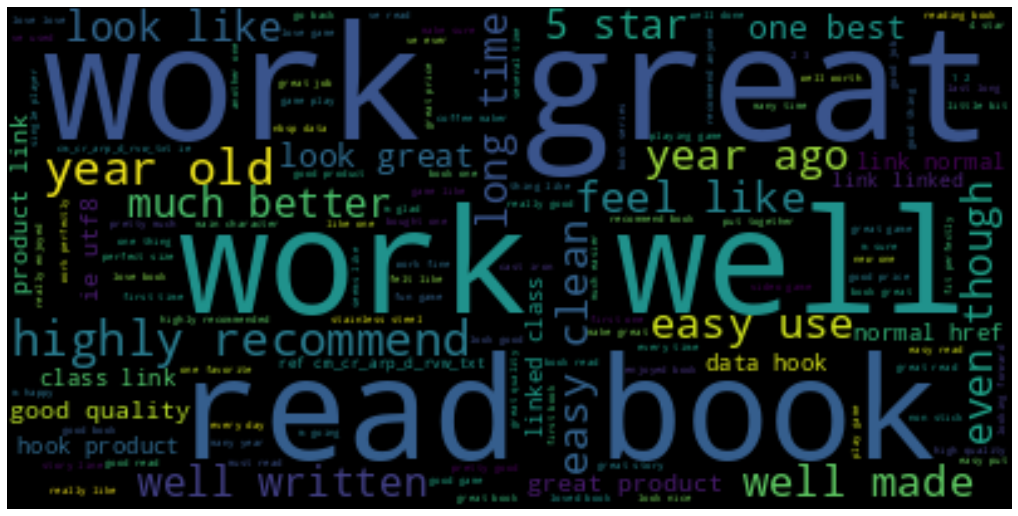

In [0]:
spark.conf.set("spark.databricks.queryWatchdog.outputRatioThreshold", 10000000)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Count the frequency of each bigram
bigram_word_freq = df_eda.select(f.explode('reviewBigrams').alias('col')).groupBy('col').count().sort(f.desc('count')).collect()

# Create a word cloud
wordcloud = WordCloud().generate_from_frequencies(dict(bigram_word_freq))

# Display the word cloud
plt.figure(figsize=(18,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

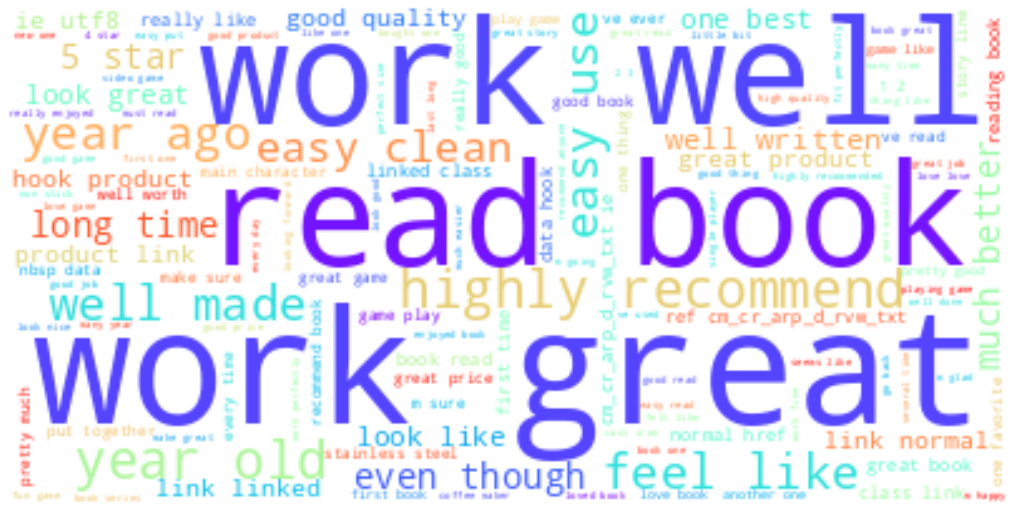

In [0]:
spark.conf.set("spark.databricks.queryWatchdog.outputRatioThreshold", 10000000)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Count the frequency of each bigram
bigram_word_freq = df_eda.select(f.explode('reviewBigrams').alias('col')).groupBy('col').count().sort(f.desc('count')).collect()

# Create a word cloud
wordcloud = WordCloud(background_color='white',
                      random_state=42,
                      colormap='rainbow').generate_from_frequencies(dict(bigram_word_freq))

# Display the word cloud
plt.figure(figsize=(18,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
#ReveiwText Team frequency (1-gram) by year
spark.conf.set("spark.databricks.queryWatchdog.outputRatioThreshold", 10000000)
from pyspark.sql import functions as f
display(df_eda.select(f.explode('reviewNgrams').alias('col'), 'year').groupBy('col','year').count().sort(f.desc('count')).collect())


col,year,count
great,2015,132590
great,2014,120871
great,2016,110190
one,2014,102492
one,2013,95495
good,2014,91086
great,2013,88779
good,2015,87696
one,2015,86523
like,2014,84285


In [0]:
# Convert Unix timestamp to readable date
from pyspark.sql.functions import date_format
from pyspark.sql.functions import from_unixtime, to_date
from pyspark.sql.types import *

df = df.withColumn("reviewTime", to_date(from_unixtime(df.unixReviewTime))) \
                                                .drop("unixReviewTime")

# Convert the data to string datatype
df = df.withColumn("reviewTime_string", date_format(("reviewTime"), "yyyy-MM-dd"))

# Extract sentiment from reviewText feature
import nltk
nltk.download('all')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf

## initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

## define the udf
sentiment_udf = udf(lambda x: sia.polarity_scores(x)["compound"])

## use the udf to add a new column "sentiment" to the dataframe
df = df.withColumn("sentiment", sentiment_udf("reviewText"))

df = df.withColumn("sentiment", df["sentiment"].cast('double'))

#df.show(5)

[nltk_data] Downloading collection 'all'
[nltk_data] | 
[nltk_data] | Downloading package abc to /root/nltk_data...
[nltk_data] | Package abc is already up-to-date!
[nltk_data] | Downloading package alpino to /root/nltk_data...
[nltk_data] | Package alpino is already up-to-date!
[nltk_data] | Downloading package averaged_perceptron_tagger to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package averaged_perceptron_tagger is already up-
[nltk_data] | to-date!
[nltk_data] | Downloading package averaged_perceptron_tagger_ru to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package averaged_perceptron_tagger_ru is already
[nltk_data] | up-to-date!
[nltk_data] | Downloading package basque_grammars to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package basque_grammars is already up-to-date!
[nltk_data] | Downloading package bcp47 to /root/nltk_data...
[nltk_data] | Package bcp47 is already up-to-date!
[nltk_data] | Downloading package biocreative_ppi to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package biocreative_ppi is already up-to-date!
[nltk_data] | Downloading package bllip_wsj_no_aux to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package bllip_wsj_no_aux is already up-to-date!
[nltk_data] | Downloading package book_grammars to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package book_grammars is already up-to-date!
[nltk_data] | Downloading package brown to /root/nltk_data...
[nltk_data] | Package brown is already up-to-date!
[nltk_data] | Downloading package brown_tei to /root/nltk_data...
[nltk_data] | Package brown_tei is already up-to-date!
[nltk_data] | Downloading package cess_cat to /root/nltk_data...
[nltk_data] | Package cess_cat is already up-to-date!
[nltk_data] | Downloading package cess_esp to /root/nltk_data...
[nltk_data] | Package cess_esp is already up-to-date!
[nltk_data] | Downloading package chat80 to /root/nltk_data...
[nltk_data] | Package chat80 is already up-to-date!
[nltk_data] | Downloading package city_database to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package city_database is already up-to-date!
[nltk_data] | Downloading package cmudict to /root/nltk_data...
[nltk_data] | Package cmudict is already up-to-date!
[nltk_data] | Downloading package comparative_sentences to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package comparative_sentences is already up-to-
[nltk_data] | date!
[nltk_data] | Downloading package comtrans to /root/nltk_data...
[nltk_data] | Package comtrans is already up-to-date!
[nltk_data] | Downloading package conll2000 to /root/nltk_data...
[nltk_data] | Package conll2000 is already up-to-date!
[nltk_data] | Downloading package conll2002 to /root/nltk_data...
[nltk_data] | Package conll2002 is already up-to-date!
[nltk_data] | Downloading package conll2007 to /root/nltk_data...
[nltk_data] | Package conll2007 is already up-to-date!
[nltk_data] | Downloading package crubadan to /root/nltk_data...
[nltk_data] | Package crubadan is already up-to-date!
[nltk_data] | Downloading package dependency_treebank to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package dependency_treebank is already up-to-date!
[nltk_data] | Downloading package dolch to /root/nltk_data...
[nltk_data] | Package dolch is already up-to-date!
[nltk_data] | Downloading package europarl_raw to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package europarl_raw is already up-to-date!
[nltk_data] | Downloading package extended_omw to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package extended_omw is already up-to-date!
[nltk_data] | Downloading package floresta to /root/nltk_data...
[nltk_data] | Package floresta is already up-to-date!
[nltk_data] | Downloading package framenet_v15 to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package framenet_v15 is already up-to-date!
[nltk_data] | Downloading package framenet_v17 to
[nltk_data] | /root/nltk_data...
[nltk_data] | Package framenet_v17 is already up-to-date!
[nltk_data] | Downloading package gazetteers to /root/nltk_data...
[nltk_da

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

#index the reviewTime feature
indexer = StringIndexer(inputCol="reviewTime_string", outputCol="reviewTime_index", handleInvalid="keep")

# string indexer for summary
indexer2 = StringIndexer(inputCol="summary", outputCol="summary_index", handleInvalid="keep")

# string indexer for asin
indexer3 = StringIndexer(inputCol="asin", outputCol="asin_index", handleInvalid="keep")

# one hot encoder for summary
summary_encoder = OneHotEncoder(inputCol='summary_index', outputCol='summaryVec')

# one hot encoder for asin
asin_encoder = OneHotEncoder(inputCol='asin_index', outputCol='asinVec')

pipeline_v1 = Pipeline(stages=[indexer, indexer2, indexer3, asin_encoder, summary_encoder])

In [0]:
pipelineFit_v1 = pipeline_v1.fit(df)
df = pipelineFit_v1.transform(df)
#df.show(5)

In [0]:
# For our intitial modeling efforts, we are not going to use the following features
drop_list = ['summary', 'summary_index', 'asin_index', 'asin', 'reviewID', 'reviewerID', 'reviewTime', 'image', 'style', 'reviewerName','reviewTime_string']
df = df.select([column for column in df.columns if column not in drop_list])
#df.show(5)
#print((df.count(), len(df.columns)))

In [0]:
df = df.na.drop(subset=["reviewText", "label"])
#df.show(5)
#print((df.count(), len(df.columns)))

In [0]:
df.printSchema()

root
-- overall: double (nullable = true)
-- verified: boolean (nullable = true)
-- reviewText: string (nullable = true)
-- label: integer (nullable = true)
-- sentiment: double (nullable = true)
-- reviewTime_index: double (nullable = false)
-- asinVec: vector (nullable = true)
-- summaryVec: vector (nullable = true)

In [0]:
df.groupBy("label").count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1| 563451|
|    0|2575259|
+-----+-------+



In [0]:
# set seed for reproducibility
(trainingData, testingData) = df.randomSplit([0.8, 0.2], seed = 47)
#print("Training Dataset Count: " + str(trainingData.count()))
#print("Test Dataset Count: " + str(testingData.count()))

In [0]:
# In Spark's MLLib, it's considered good practices to combine all the preprocessing steps into a pipeline.
# That way, you can run the same steps on both the training data, and testing data and beyond (new data)
# without copying and pasting any code.

# It is possible to run all of these steps one-by-one, outside of a Pipeline, if desired. But that's
# not how I am going to do it here.

from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF


# We'll tokenize the text using a simple RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="reviewText", outputCol="words", pattern="\\W")


# Remove standard Stopwords
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")



pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover])

In [0]:
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(trainingData)
trainingDataTransformed = pipelineFit.transform(trainingData)
#trainingDataTransformed.show(5)

In [0]:
#lemmatize filtered words
import nltk
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemmatizer = WordNetLemmatizer()

# function to lemmatize the text
def lemmatize_text(filtered):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered]
    return lemmatized_words

lemmatize_udf = udf(lemmatize_text, ArrayType(StringType()))

trainingDataTransformed2 = trainingDataTransformed.withColumn("lemmatized_text", lemmatize_udf("filtered"))

#trainingDataTransformed2.show(5)

In [0]:
# Getting tf-idf values

from pyspark.ml.feature import HashingTF, VectorAssembler, IDF
hashtf = HashingTF(numFeatures=2**12, inputCol="lemmatized_text", outputCol='rawFeatures')

# create the idf
idf = IDF(inputCol="rawFeatures", outputCol="IDFfeatures")

assembler = VectorAssembler(inputCols=["verified", "overall", "reviewTime_index", "asinVec", "summaryVec", "sentiment", "IDFfeatures"], outputCol="features")

pipeline2 = Pipeline(stages=[hashtf, idf, assembler])



In [0]:
pipelineFit2 = pipeline2.fit(trainingDataTransformed2)
trainingDataTransformed3 = pipelineFit2.transform(trainingDataTransformed2)
#trainingDataTransformed3.show(5)

In [0]:
from pyspark.ml.classification import LogisticRegression

# More classification docs: https://spark.apache.org/docs/latest/ml-classification-regression.html

lr = LogisticRegression(maxIter=25, regParam=0.2, elasticNetParam=0)
lrModel = lr.fit(trainingDataTransformed3)

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr = LogisticRegression()

paramGrid = ParamGridBuilder()\
    .addGrid(lr.maxIter, [20, 30])\
    .addGrid(lr.regParam, [0.3, 0.4])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

pipeline_lr = Pipeline(stages=[cv])

lrModel = pipeline_lr.fit(trainingDataTransformed3)

bestModel = lrModel.stages[0].bestModel

# Extract the best parameters
bestMaxIter = bestModel._java_obj.getMaxIter()
bestRegParam = bestModel._java_obj.getRegParam()
bestElasticNetParam = bestModel._java_obj.getElasticNetParam()

# Print out the best parameters
print("Best maxIter: ", bestMaxIter)
print("Best regParam: ", bestRegParam)
print("Best elasticNetParam: ", bestElasticNetParam)

Best maxIter: 30
Best regParam: 0.3
Best elasticNetParam: 0.0

In [0]:
#from pyspark.ml.classification import RandomForestClassifier
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
#rf = RandomForestClassifier(labelCol="label", featuresCol="features")
#rfModel = rf.fit(trainingDataTransformed3)

In [0]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

print("Training Accuracy:  " + str(trainingSummary.accuracy))
print("Training Precision: " + str(trainingSummary.precisionByLabel))
print("Training Recall:    " + str(trainingSummary.recallByLabel))
print("Training FMeasure:  " + str(trainingSummary.fMeasureByLabel()))
print("Training AUC:       " + str(trainingSummary.areaUnderROC))

Training Accuracy: 0.9251827861526426
Training Precision: [0.9209440092928247, 0.9580025269489006]
Training Recall: [0.9941447564124526, 0.6101490141831708]
Training FMeasure: [0.9561454008642245, 0.7454946566973771]
Training AUC: 0.9696480719064258

In [0]:
trainingSummary = lrModel.summary

print("Training Accuracy:  " + str(trainingSummary.accuracy))
print("Training Precision: " + str(trainingSummary.precisionByLabel))
print("Training Recall:    " + str(trainingSummary.recallByLabel))
print("Training FMeasure:  " + str(trainingSummary.fMeasureByLabel()))
print("Training AUC:       " + str(trainingSummary.areaUnderROC))

Training Accuracy: 0.925203090195735
Training Precision: [0.9209696655827969, 0.9579717306126426]
Training Recall: [0.9941389331965524, 0.610288673414646]
Training FMeasure: [0.9561565348643246, 0.7455895655376749]
Training AUC: 0.9696447759550556

In [0]:
trainingSummary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|1.538050993425681E-4|0.004268299446496511|
|3.022731132189903E-4| 0.00841902099763735|
|4.822784503044565E-4|0.012469912260268655|
|6.676208728560685E-4| 0.01652080352289996|
|8.757672060357585E-4|0.020383126462791033|
|0.001104291501904369|0.024207735738134062|
|0.001334271366536474| 0.02803900036604439|
|0.001556488197763276| 0.03183033287855091|
|0.001789864389510...|0.035654942153893934|
|0.002030518425074...| 0.03937750268987166|
|0.002276509546105...|0.043075660266435944|
|0.002534145217243638| 0.04672723037502912|
|0.002792751267557...| 0.05040764034474726|
|0.003057179592925936| 0.05404146284649429|
|0.003323063487057...|0.057637571683693274|
| 0.00359913636253366| 0.06122036981575766|
|0.003892190873583853| 0.06478985724268743|
|0.004184275005458383| 0.06826173283196343|
|0.004470051672691104| 0.0718001

In [0]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
for objective in objectiveHistory:
    print(objective)

0.4705704512667985
0.4344360573360366
0.41160601784214834
0.40288422069037655
0.3976794850934062
0.39620784141929927
0.3928080628899346
0.39195238222380246
0.391603957399046
0.3914702021811439
0.39124907985078106
0.39108830544112017
0.3910421673055425
0.3910109001903958
0.39100782710819554
0.3910061233309457
0.39100586438128154
0.39100577135007825
0.3910057341578627
0.3910057270329267
0.3910057161439611


In [0]:
testingDataTransform = pipelineFit.transform(testingData)
#testingDataTransform.show(5)

In [0]:
#lemmatize filtered words
import nltk
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemmatizer = WordNetLemmatizer()

# function to lemmatize the text
def lemmatize_text(filtered):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered]
    return lemmatized_words

lemmatize_udf = udf(lemmatize_text, ArrayType(StringType()))

testingDataTransform2 = testingDataTransform.withColumn("lemmatized_text", lemmatize_udf("filtered"))
#testingDataTransform2.show(5)

In [0]:
testingDataTransform3 = pipelineFit2.transform(testingDataTransform2)
#testingDataTransform3.show(5)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = lrModel.transform(testingDataTransform3)
#predictions.show(5)

evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8888133459202431

In [0]:
#Transform the  entire training dataset
FullDataTransform = pipelineFit.transform(df)
FullDataTransform.show(5)

+-------+--------+--------------------+-----+---------+----------------+--------------------+--------------------+--------------------+--------------------+
overall|verified| reviewText|label|sentiment|reviewTime_index| asinVec| summaryVec| words| filtered|
+-------+--------+--------------------+-----+---------+----------------+--------------------+--------------------+--------------------+--------------------+
 5.0| true|Great product, lo...| 0| 0.8715| 374.0|(65205,[59291],[1...| (1640535,[0],[1.0])|[great, product, ...|[great, product, ...|
 5.0| false|The King, the Mic...| 0| 0.9698| 4547.0|(65205,[28138],[1...|(1640535,[311265]...|[the, king, the, ...|[king, mice, chee...|
 5.0| true|This game is a bi...| 0| 0.7543| 976.0|(65205,[35432],[1...|(1640535,[1520290...|[this, game, is, ...|[game, bit, hard,...|
 3.0| true|Pretty flimsy, bu...| 1| 0.2732| 297.0|(65205,[59291],[1...|(1640535,[64],[1.0])|[pretty, flimsy, ...|[pretty, flimsy, ...|
 5.0| true| The kids loved it!| 0| 0.636| 724.0|(65205,[28138],[1...| (1640535,[0],[1.0])|[the, kids, loved...| [kids, loved]|
+-------+--------+--------------------+-----+---------+----------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
#lemmatize the  entire training dataset
import nltk
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemmatizer = WordNetLemmatizer()

# function to lemmatize the text
def lemmatize_text(filtered):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered]
    return lemmatized_words

lemmatize_udf = udf(lemmatize_text, ArrayType(StringType()))

FullDataTransform2 = FullDataTransform.withColumn("lemmatized_text", lemmatize_udf("filtered"))
FullDataTransform2.show(5)

+-------+--------+--------------------+-----+---------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
overall|verified| reviewText|label|sentiment|reviewTime_index| asinVec| summaryVec| words| filtered| lemmatized_text|
+-------+--------+--------------------+-----+---------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
 5.0| true|Great product, lo...| 0| 0.8715| 374.0|(65205,[59291],[1...| (1640535,[0],[1.0])|[great, product, ...|[great, product, ...|[great, product, ...|
 5.0| false|The King, the Mic...| 0| 0.9698| 4547.0|(65205,[28138],[1...|(1640535,[311265]...|[the, king, the, ...|[king, mice, chee...|[king, mouse, che...|
 5.0| true|This game is a bi...| 0| 0.7543| 976.0|(65205,[35432],[1...|(1640535,[1520290...|[this, game, is, ...|[game, bit, hard,...|[game, bit, hard,...|
 3.0| true|Pretty flimsy, bu...| 1| 0.2732| 297.0|(65205,[59291],[1...|(1640535,[64],[1.0])|[pretty, flimsy, ...|[pretty, flimsy, ...|[pretty, flimsy, ...|
 5.0| true| The kids loved it!| 0| 0.636| 724.0|(65205,[28138],[1...| (1640535,[0],[1.0])|[the, kids, loved...| [kids, loved]| [kid, loved]|
+-------+--------+--------------------+-----+---------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
#Transform the  entire training dataset
FullDataTransform3 = pipelineFit2.transform(FullDataTransform2)
#FullDataTransform3.show(5)

In [0]:
from pyspark.ml.classification import LogisticRegression

# More classification docs: https://spark.apache.org/docs/latest/ml-classification-regression.html

lr = LogisticRegression(maxIter=25, regParam=0.2, elasticNetParam=0)
lrModel = lr.fit(FullDataTransform3)

In [0]:
#from pyspark.ml.classification import RandomForestClassifier
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
#rf = RandomForestClassifier(labelCol="label", featuresCol="features")
#rfModel = rf.fit(FullDataTransform3)


In [0]:
#LGBM seem not to be working in this environmet
#from lightgbm4spark import LGBMClassifier
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
#lgbm = LGBMClassifier(objective='binary', num_leaves=31)
#lgbmModel = lgbm.fit(FullDataTransform3)

In [0]:
#from pyspark.ml.classification import GBTClassifier
#from pyspark.ml.evaluation import BinaryClassificationEvaluator
#gbt = GBTClassifier(labelCol="label", featuresCol="features")
#gbtModel = gbt.fit(FullDataTransform3)

In [0]:
# Load in the tables
test_df = spark.sql("select * from default.reviews_test")
test_df.show(5)
print((test_df.count(), len(test_df.columns)))

+--------+-------+--------+-----------+--------------+----------+------------+--------------------+--------------------+--------------+
reviewID|overall|verified| reviewTime| reviewerID| asin|reviewerName| reviewText| summary|unixReviewTime|
+--------+-------+--------+-----------+--------------+----------+------------+--------------------+--------------------+--------------+
80000001| 4.0| false|07 27, 2015|A1JGAP0185YJI6|0700026657| travis|I played it a whi...|But in spite of t...| 1437955200|
80000002| 5.0| true| 03 3, 2014|A1WK5I4874S3O2|0700026657| WhiteSkull|I bought this gam...|A very good game ...| 1393804800|
80000003| 5.0| true|01 12, 2013|A1YDQQJDRHM0FJ|0001713353| Leila|I am very happy w...|One of our famili...| 1357948800|
80000004| 5.0| true|11 20, 2011|A2E6AHFDJ3JBAZ|0681795107| robosolo|I purchased two o...|Insulated stainle...| 1321747200|
80000005| 5.0| false|06 28, 2011|A38NXTZUFB1O2K|0700099867| FiSH|I'm not quite fin...| Best in the series!| 1309219200|
+--------+-------+--------+-----------+--------------+----------+------------+--------------------+--------------------+--------------+
only showing top 5 rows

(348621, 10)

In [0]:
# Convert Unix timestamp to readable date
from pyspark.sql.functions import date_format
from pyspark.sql.functions import from_unixtime, to_date
from pyspark.sql.types import *

test_df = test_df.withColumn("reviewTime", to_date(from_unixtime(test_df.unixReviewTime)))

# Convert the data to string datatype
test_df = test_df.withColumn("reviewTime_string", date_format(("reviewTime"), "yyyy-MM-dd"))

# Extract sentiment from reviewText feature
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf

## initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

## define the udf
sentiment_udf = udf(lambda x: sia.polarity_scores(x)["compound"])

## use the udf to add a new column "sentiment" to the dataframe
test_df = test_df.withColumn("sentiment", sentiment_udf("reviewText"))

test_df = test_df.withColumn("sentiment", test_df["sentiment"].cast('double'))

test_df.show(5)

+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+
reviewID|overall|verified|reviewTime| reviewerID| asin|reviewerName| reviewText| summary|unixReviewTime|reviewTime_string|sentiment|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+
80000001| 4.0| false|2015-07-27|A1JGAP0185YJI6|0700026657| travis|I played it a whi...|But in spite of t...| 1437955200| 2015-07-27| 0.8302|
80000002| 5.0| true|2014-03-03|A1WK5I4874S3O2|0700026657| WhiteSkull|I bought this gam...|A very good game ...| 1393804800| 2014-03-03| 0.4926|
80000003| 5.0| true|2013-01-12|A1YDQQJDRHM0FJ|0001713353| Leila|I am very happy w...|One of our famili...| 1357948800| 2013-01-12| 0.917|
80000004| 5.0| true|2011-11-20|A2E6AHFDJ3JBAZ|0681795107| robosolo|I purchased two o...|Insulated stainle...| 1321747200| 2011-11-20| 0.9859|
80000005| 5.0| false|2011-06-28|A38NXTZUFB1O2K|0700099867| FiSH|I'm not quite fin...| Best in the series!| 1309219200| 2011-06-28| 0.9876|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+
only showing top 5 rows

In [0]:
test_df = pipelineFit_v1.transform(test_df)
test_df.show(5)

+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+
reviewID|overall|verified|reviewTime| reviewerID| asin|reviewerName| reviewText| summary|unixReviewTime|reviewTime_string|sentiment|reviewTime_index|summary_index|asin_index| asinVec| summaryVec|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+
80000001| 4.0| false|2015-07-27|A1JGAP0185YJI6|0700026657| travis|I played it a whi...|But in spite of t...| 1437955200| 2015-07-27| 0.8302| 375.0| 1640535.0| 35432.0|(65205,[35432],[1...| (1640535,[],[])|
80000002| 5.0| true|2014-03-03|A1WK5I4874S3O2|0700026657| WhiteSkull|I bought this gam...|A very good game ...| 1393804800| 2014-03-03| 0.4926| 665.0| 1640535.0| 35432.0|(65205,[35432],[1...| (1640535,[],[])|
80000003| 5.0| true|2013-01-12|A1YDQQJDRHM0FJ|0001713353| Leila|I am very happy w...|One of our famili...| 1357948800| 2013-01-12| 0.917| 937.0| 1640535.0| 28138.0|(65205,[28138],[1...| (1640535,[],[])|
80000004| 5.0| true|2011-11-20|A2E6AHFDJ3JBAZ|0681795107| robosolo|I purchased two o...|Insulated stainle...| 1321747200| 2011-11-20| 0.9859| 2595.0| 1640535.0| 39451.0|(65205,[39451],[1...| (1640535,[],[])|
80000005| 5.0| false|2011-06-28|A38NXTZUFB1O2K|0700099867| FiSH|I'm not quite fin...| Best in the series!| 1309219200| 2011-06-28| 0.9876| 2163.0| 29066.0| 21065.0|(65205,[21065],[1...|(1640535,[29066],...|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+
only showing top 5 rows

In [0]:
test_df_Transform = pipelineFit.transform(test_df)
test_df_Transform.show(5)

+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+
reviewID|overall|verified|reviewTime| reviewerID| asin|reviewerName| reviewText| summary|unixReviewTime|reviewTime_string|sentiment|reviewTime_index|summary_index|asin_index| asinVec| summaryVec| words| filtered|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+
80000001| 4.0| false|2015-07-27|A1JGAP0185YJI6|0700026657| travis|I played it a whi...|But in spite of t...| 1437955200| 2015-07-27| 0.8302| 375.0| 1640535.0| 35432.0|(65205,[35432],[1...| (1640535,[],[])|[i, played, it, a...|[played, alright,...|
80000002| 5.0| true|2014-03-03|A1WK5I4874S3O2|0700026657| WhiteSkull|I bought this gam...|A very good game ...| 1393804800| 2014-03-03| 0.4926| 665.0| 1640535.0| 35432.0|(65205,[35432],[1...| (1640535,[],[])|[i, bought, this,...|[bought, game, th...|
80000003| 5.0| true|2013-01-12|A1YDQQJDRHM0FJ|0001713353| Leila|I am very happy w...|One of our famili...| 1357948800| 2013-01-12| 0.917| 937.0| 1640535.0| 28138.0|(65205,[28138],[1...| (1640535,[],[])|[i, am, very, hap...|[happy, book, one...|
80000004| 5.0| true|2011-11-20|A2E6AHFDJ3JBAZ|0681795107| robosolo|I purchased two o...|Insulated stainle...| 1321747200| 2011-11-20| 0.9859| 2595.0| 1640535.0| 39451.0|(65205,[39451],[1...| (1640535,[],[])|[i, purchased, tw...|[purchased, two, ...|
80000005| 5.0| false|2011-06-28|A38NXTZUFB1O2K|0700099867| FiSH|I'm not quite fin...| Best in the series!| 1309219200| 2011-06-28| 0.9876| 2163.0| 29066.0| 21065.0|(65205,[21065],[1...|(1640535,[29066],...|[i, m, not, quite...|[m, quite, finish...|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
#lemmatize filtered words
import nltk
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemmatizer = WordNetLemmatizer()

# function to lemmatize the text
def lemmatize_text(filtered):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered]
    return lemmatized_words

lemmatize_udf = udf(lemmatize_text, ArrayType(StringType()))

test_df_Transform2 = test_df_Transform.withColumn("lemmatized_text", lemmatize_udf("filtered"))
test_df_Transform2.show(5)

+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
reviewID|overall|verified|reviewTime| reviewerID| asin|reviewerName| reviewText| summary|unixReviewTime|reviewTime_string|sentiment|reviewTime_index|summary_index|asin_index| asinVec| summaryVec| words| filtered| lemmatized_text|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
80000001| 4.0| false|2015-07-27|A1JGAP0185YJI6|0700026657| travis|I played it a whi...|But in spite of t...| 1437955200| 2015-07-27| 0.8302| 375.0| 1640535.0| 35432.0|(65205,[35432],[1...| (1640535,[],[])|[i, played, it, a...|[played, alright,...|[played, alright,...|
80000002| 5.0| true|2014-03-03|A1WK5I4874S3O2|0700026657| WhiteSkull|I bought this gam...|A very good game ...| 1393804800| 2014-03-03| 0.4926| 665.0| 1640535.0| 35432.0|(65205,[35432],[1...| (1640535,[],[])|[i, bought, this,...|[bought, game, th...|[bought, game, th...|
80000003| 5.0| true|2013-01-12|A1YDQQJDRHM0FJ|0001713353| Leila|I am very happy w...|One of our famili...| 1357948800| 2013-01-12| 0.917| 937.0| 1640535.0| 28138.0|(65205,[28138],[1...| (1640535,[],[])|[i, am, very, hap...|[happy, book, one...|[happy, book, one...|
80000004| 5.0| true|2011-11-20|A2E6AHFDJ3JBAZ|0681795107| robosolo|I purchased two o...|Insulated stainle...| 1321747200| 2011-11-20| 0.9859| 2595.0| 1640535.0| 39451.0|(65205,[39451],[1...| (1640535,[],[])|[i, purchased, tw...|[purchased, two, ...|[purchased, two, ...|
80000005| 5.0| false|2011-06-28|A38NXTZUFB1O2K|0700099867| FiSH|I'm not quite fin...| Best in the series!| 1309219200| 2011-06-28| 0.9876| 2163.0| 29066.0| 21065.0|(65205,[21065],[1...|(1640535,[29066],...|[i, m, not, quite...|[m, quite, finish...|[m, quite, finish...|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
test_df_Transform3 = pipelineFit2.transform(test_df_Transform2)
test_df_Transform3.show(5)

+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
reviewID|overall|verified|reviewTime| reviewerID| asin|reviewerName| reviewText| summary|unixReviewTime|reviewTime_string|sentiment|reviewTime_index|summary_index|asin_index| asinVec| summaryVec| words| filtered| lemmatized_text| rawFeatures| IDFfeatures| features|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
80000001| 4.0| false|2015-07-27|A1JGAP0185YJI6|0700026657| travis|I played it a whi...|But in spite of t...| 1437955200| 2015-07-27| 0.8302| 375.0| 1640535.0| 35432.0|(65205,[35432],[1...| (1640535,[],[])|[i, played, it, a...|[played, alright,...|[played, alright,...|(10000,[2,6,14,24...|(10000,[2,6,14,24...|(1715744,[1,2,354...|
80000002| 5.0| true|2014-03-03|A1WK5I4874S3O2|0700026657| WhiteSkull|I bought this gam...|A very good game ...| 1393804800| 2014-03-03| 0.4926| 665.0| 1640535.0| 35432.0|(65205,[35432],[1...| (1640535,[],[])|[i, bought, this,...|[bought, game, th...|[bought, game, th...|(10000,[2,22,30,3...|(10000,[2,22,30,3...|(1715744,[0,1,2,3...|
80000003| 5.0| true|2013-01-12|A1YDQQJDRHM0FJ|0001713353| Leila|I am very happy w...|One of our famili...| 1357948800| 2013-01-12| 0.917| 937.0| 1640535.0| 28138.0|(65205,[28138],[1...| (1640535,[],[])|[i, am, very, hap...|[happy, book, one...|[happy, book, one...|(10000,[0,1,154,1...|(10000,[0,1,154,1...|(1715744,[0,1,2,2...|
80000004| 5.0| true|2011-11-20|A2E6AHFDJ3JBAZ|0681795107| robosolo|I purchased two o...|Insulated stainle...| 1321747200| 2011-11-20| 0.9859| 2595.0| 1640535.0| 39451.0|(65205,[39451],[1...| (1640535,[],[])|[i, purchased, tw...|[purchased, two, ...|[purchased, two, ...|(10000,[1,3,4,6,7...|(10000,[1,3,4,6,7...|(1715744,[0,1,2,3...|
80000005| 5.0| false|2011-06-28|A38NXTZUFB1O2K|0700099867| FiSH|I'm not quite fin...| Best in the series!| 1309219200| 2011-06-28| 0.9876| 2163.0| 29066.0| 21065.0|(65205,[21065],[1...|(1640535,[29066],...|[i, m, not, quite...|[m, quite, finish...|[m, quite, finish...|(10000,[1,2,3,4,6...|(10000,[1,2,3,4,6...|(1715744,[1,2,210...|
+--------+-------+--------+----------+--------------+----------+------------+--------------------+--------------------+--------------+-----------------+---------+----------------+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
predictions = lrModel.transform(test_df_Transform3)

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

probelement=udf(lambda v:float(v[1]),FloatType())
submission_data = predictions.select('reviewID', probelement('probability')).withColumnRenamed('<lambda>(probability)', 'label')

In [0]:
#rf_predictions = rfModel.transform(test_df_Transform3)

In [0]:
#from pyspark.sql.functions import udf
#from pyspark.sql.types import FloatType

#probelement=udf(lambda v:float(v[1]),FloatType())
#submission_data = rf_predictions.select('reviewID', probelement('probability')).withColumnRenamed('<lambda>(probability)', 'label')

In [0]:
#lgbm_predictions = lgbmModel.transform(test_df_Transform3)

In [0]:
#from pyspark.sql.functions import udf
#from pyspark.sql.types import FloatType

#probelement=udf(lambda v:float(v[1]),FloatType())
#submission_data = lgbm_predictions.select('reviewID', probelement('probability')).withColumnRenamed('<lambda>(probability)', 'label')

In [0]:
#gbt_predictions = gbtModel.transform(test_df_Transform3)

In [0]:
#from pyspark.sql.functions import udf
#from pyspark.sql.types import FloatType

#probelement=udf(lambda v:float(v[1]),FloatType())
#submission_data = gbt_predictions.select('reviewID', probelement('probability')).withColumnRenamed('<lambda>(probability)', 'label')

In [0]:
display(submission_data.select('reviewID', 'label'))

reviewID,label
80000001,0.07440027
80000002,0.11987921
80000003,0.07986579
80000004,0.48559844
80000005,0.56517684
80000006,0.23115142
80000007,0.11637648
80000008,0.65950245
80000009,0.1345113
80000010,0.7650229
